## Set up

In [1]:
import pickle
from copy import deepcopy
import pandas as pd
import numpy as np
from osgeo.gdalconst import *
from osgeo import gdal
from scipy.ndimage import gaussian_filter, median_filter
#visualization
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
#import custom functions
from custom_functions import *

## Combine Forests with different features

In [ ]:
#load in models - 14_bbin14_13
forest_14 = pickle.load(open('../models/forest14.sav', 'rb'))
forest_13 = pickle.load(open('../models/forest_13.sav', 'rb'))
xgb_bin14 = pickle.load(open('../models/xgb_bin14.sav', 'rb'))
forest_15 = pickle.load(open('../models/forest15.sav', 'rb'))

In [ ]:
#load in models
forest_14 = pickle.load(open('../models/forest14.sav', 'rb'))
forest_15 = pickle.load(open('../models/forest15.sav', 'rb'))
forest_13 = pickle.load(open('../models/forest_13.sav', 'rb'))
xgb_bin14_v2 = pickle.load(open('../models/xgb_bin14_v2.sav', 'rb'))

In [3]:
#load in models
forest_15 = pickle.load(open('../models/forest15.sav', 'rb'))
forest_16 = pickle.load(open('../models/forest_16.sav', 'rb'))
xgb_bin14 = pickle.load(open('../models/xgb_bin14.sav', 'rb'))

### Demo test

In [ ]:
#Processing for 14_bbin14_13
process_14_bin14_13 = {
                       'target_edge': ['B8A', None, None],
                        'target_outlier' : ['B01f', False, False],
                        'gaussian' : [False, False, True],
                        'clustering' : [False, False, '../models/kcluster_13.sav'],
                        'calculate_layers' : [True, 'Extra', True]}
binary_14_bin14_13 = {'model': [1], 'class': [14]}

combo_pred, y_true = predict_combo([forest_14, xgb_bin14, forest_13], '../data_tests/demo_site.csv',  '../data_tests/demo/raws',
                                  process_dict = process_14_bin14_13, binary = binary_14_bin14_13)

In [ ]:
#Processing for 15_bbin14_13
process_15_bin14_13 = {
                       'target_edge': ['B8A', None, None],
                        'geocoords': [True, False, False],
                        'target_outlier' : [False, False, False],
                        'gaussian' : [False, False, True],
                        'clustering' : [False, False, '../models/kcluster_13.sav'],
                        'calculate_layers' : [True, 'Extra', True]}
binary_15_bin14_13 = {'model': [1], 'class': [14]}

combo_pred, y_true = predict_combo([forest_15, xgb_bin14, forest_13], '../data_tests/demo_site.csv',  '../data_tests/demo/raws',
                                  class_lists = [[14], [15, 17]], process_dict = process_15_bin14_13, binary = binary_15_bin14_13)

In [4]:
#Processing for 15_bbin14_16
process_15_bin14_16 = {
                       'target_edge': ['B8A', None, 'B8A'],
                        'geocoords': [True, False, True],
                        'target_outlier' : [False, False, 'B01f'],
                        'gaussian' : [False, False, True],
                        'clustering' : [False, False, False],
                        'calculate_layers' : [True, 'Extra', True]}
binary_15_bin14_16 = {'model': [1], 'class': [14]}

#generate process data and predicitons from each model
combo_pred_list, y_true = predict_combo([forest_15, xgb_bin14, forest_16], '../data_tests/demo_site.csv',  '../data_tests/demo/raws',
                                   process_dict = process_15_bin14_16, binary = binary_15_bin14_16)

getting edge
getting edge


In [20]:
demo_site = pd.read_csv('../data_tests/demo_site.csv')
y_true = demo_site['land_cover']
y_true = y_true.values.reshape(2500, 2100).T
y_true = y_true.flatten()

In [22]:
def combine_pred(pred_list, class_lists, binary):
 
    bin_pred = pred_list[binary['model'][0]]
    bin_pred = bin_pred.replace(1, binary['class'][0])
    pred_list[binary['model'][0]] = bin_pred
    
    
    #take first model as base model
    base_pred = pred_list[0]
    
    #select only classes in list from additional forest
    for i in range(len(class_lists)):
        subset = pred_list[i + 1][pred_list[i + 1].isin(class_lists[i]) ]
        #updat base_pred with subset
        base_pred.update(subset)
        #convert to int
        base_pred = base_pred.astype('int')
    
    return base_pred

#combine predictions based on class list
combo_pred = combine_pred(combo_pred_list, class_lists = [[14], [15]], binary = binary_15_bin14_16)

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, balanced_accuracy_score

C:\Users\fynn\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


0.39714681446654615
0.5682051428571429


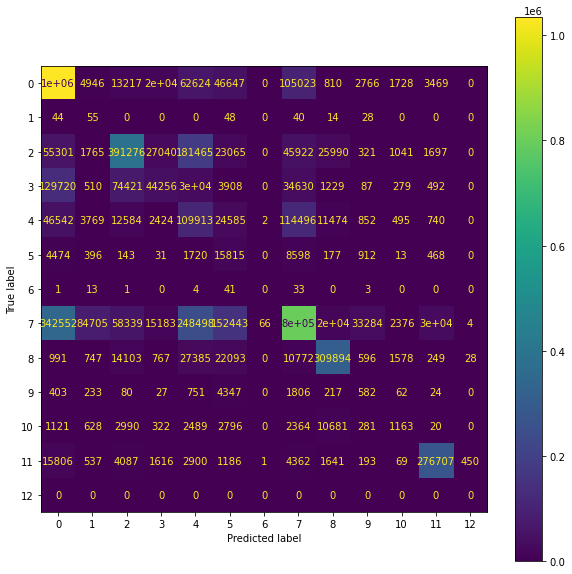

In [23]:
#accuracy
print(balanced_accuracy_score(y_true, combo_pred))
print(accuracy_score(y_true, combo_pred))

#confusion matrix
cm_forest = confusion_matrix(y_true, combo_pred)
cm_forest_fig = ConfusionMatrixDisplay(confusion_matrix = cm_forest)
fig, ax = plt.subplots(figsize=(10,10))
cm_forest_fig.plot(ax = ax)

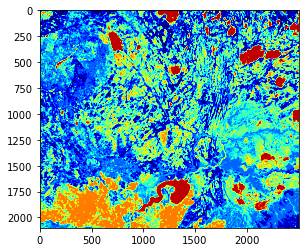

In [24]:
map_pred = np.asarray(combo_pred.values).reshape(2100, 2500)
cmap = cm.get_cmap('jet', 19)    # 11 discrete colors
prediction_map = plt.imshow(map_pred, cmap=cmap)

In [ ]:
map_pred = np.asarray(y_true).reshape(2100, 2500)
cmap = cm.get_cmap('jet', 19)    # 11 discrete colors
prediction_map = plt.imshow(map_pred, cmap=cmap)

In [25]:
#OPTIONAL: save matrix and map as versions
#save confusion matrix
cm_forest_fig.figure_.savefig(os.path.join('evaluation', 'demo/combo', '15_xgbin14_16_cm.png'))

#save prediction map
prediction_map.figure.savefig(os.path.join('evaluation', 'demo/combo', '15_xgbin14_16_map.png'))

In [ ]:
print(classification_report(y_true, combo_pred, zero_division = 1))

### Random extent test

#### Combination

In [32]:
combo_pred_list = predict_combo([forest_15, xgb_bin14, forest_16], None, '../data_tests/calgary/raws', index = [-14, -11], 
                                   process_dict = process_15_bin14_16, binary = binary_15_bin14_16, nrcan_name = 'NRCAN_transformed.tif')

getting edge
getting edge


In [33]:
def combine_pred(pred_list, class_lists, binary):
 
    bin_pred = pred_list[binary['model'][0]]
    bin_pred = bin_pred.replace(1, binary['class'][0])
    pred_list[binary['model'][0]] = bin_pred
    
    
    #take first model as base model
    base_pred = pred_list[0]
    
    #select only classes in list from additional forest
    for i in range(len(class_lists)):
        subset = pred_list[i + 1][pred_list[i + 1].isin(class_lists[i]) ]
        #updat base_pred with subset
        base_pred.update(subset)
        #convert to int
        base_pred = base_pred.astype('int')
    
    return base_pred

#combine predictions based on class list
combo_pred = combine_pred(combo_pred_list, class_lists = [[14], [15]], binary = binary_15_bin14_16)

In [35]:
cal_raws = gdal_to_dataframe('../data_tests/calgary/raws')
y_true = cal_raws['y']



In [ ]:
combo_pred = combine_pred(combo_pred_list, class_lists = [[14], [15]], binary = binary_15_bin14_16)

In [ ]:
combo_pred, y_true = predict_combo([forest_14, xgb_bin14, forest_13], None, '../data_tests/calgary/raws', index = [-14, -11], 
                                   process_dict = process_10_bin14_13, binary = binary_10_bin14_13, nrcan_name = 'NRCAN_transformed.tif')

0.32179886984699974
0.5573088552915767


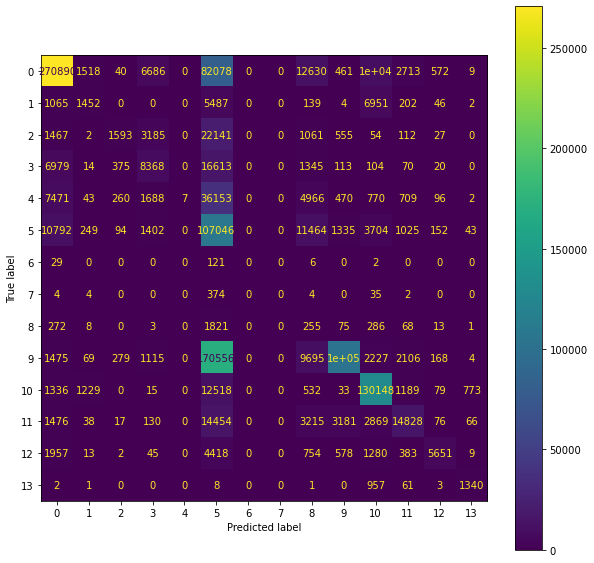

In [36]:
#accuracy
print(balanced_accuracy_score(y_true, combo_pred))
print(accuracy_score(y_true, combo_pred))

#confusion matrix
cm_forest = confusion_matrix(y_true, combo_pred)
cm_forest_fig = ConfusionMatrixDisplay(confusion_matrix = cm_forest)
fig, ax = plt.subplots(figsize=(10,10))
cm_forest_fig.plot(ax = ax)

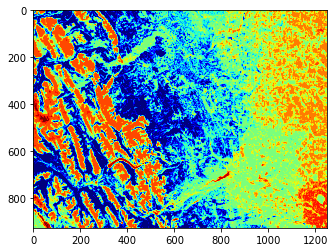

In [37]:
map_pred = np.asarray(combo_pred.values).reshape(926, 1250)
cmap = cm.get_cmap('jet', 19)    # 11 discrete colors
prediction_map = plt.imshow(map_pred, cmap=cmap)

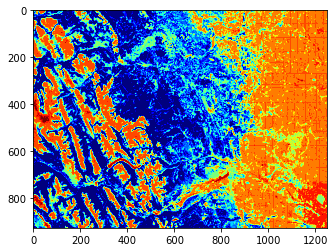

In [38]:
map_pred = np.asarray(y_true).reshape(926, 1250)
cmap = cm.get_cmap('jet', 19)    # 11 discrete colors
prediction_map = plt.imshow(map_pred, cmap=cmap)

In [ ]:
print(classification_report(y_true, combo_pred, zero_division = 1))

#### Forest only

In [ ]:
#X_ran, y_ran = process_data(None, '../data_tests/trois/raws', nrcan_name = 'NRCAN_transformed.tif', index = [-14, -11], gaussian = True, clustering = 'models/kcluster_13.sav', calculate_layers = True)
X_ran, y_ran = process_data(None, '../data_tests/calgary/raws', nrcan_name = 'NRCAN_transformed.tif', index = [-14, -11], target_edge = 'B8A', geocoords = True,target_outlier = 'B01f', calculate_layers = True, gaussian = True)

In [ ]:
forest_pred = forest_14.predict(X_ran)

In [ ]:
map_pred = np.asarray(forest_pred).reshape(926, 1250)
cmap = cm.get_cmap('jet', 19)    # 11 discrete colors
prediction_map = plt.imshow(map_pred, cmap=cmap)

In [ ]:
map_pred = np.asarray(y_ran.values).reshape(926, 1250)
cmap = cm.get_cmap('jet', 19)    # 11 discrete colors
prediction_map = plt.imshow(map_pred, cmap=cmap)

In [ ]:
print(balanced_accuracy_score(y_ran, forest_pred))
print(accuracy_score(y_ran, forest_pred))

#confusion matrix
cm_forest = confusion_matrix(y_true, forest_pred)
cm_forest_fig = ConfusionMatrixDisplay(confusion_matrix = cm_forest, display_labels = forest_10.classes_)
fig, ax = plt.subplots(figsize=(10,10))
cm_forest_fig.plot(ax = ax)

In [ ]:
print(classification_report(y_true, combo_pred, zero_division = 1))

In [ ]:
print(classification_report(y_true, forest_pred, zero_division = 1))

## Combine seperate models

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier